[Step 20]  MSE Loss=3.9402,  SE Loss=0.123570
[Step 40]  MSE Loss=0.1078,  SE Loss=0.010393
[Step 60]  MSE Loss=0.1821,  SE Loss=0.000776
[Step 80]  MSE Loss=0.0809,  SE Loss=0.000205
[Step 100]  MSE Loss=0.0279,  SE Loss=0.000028


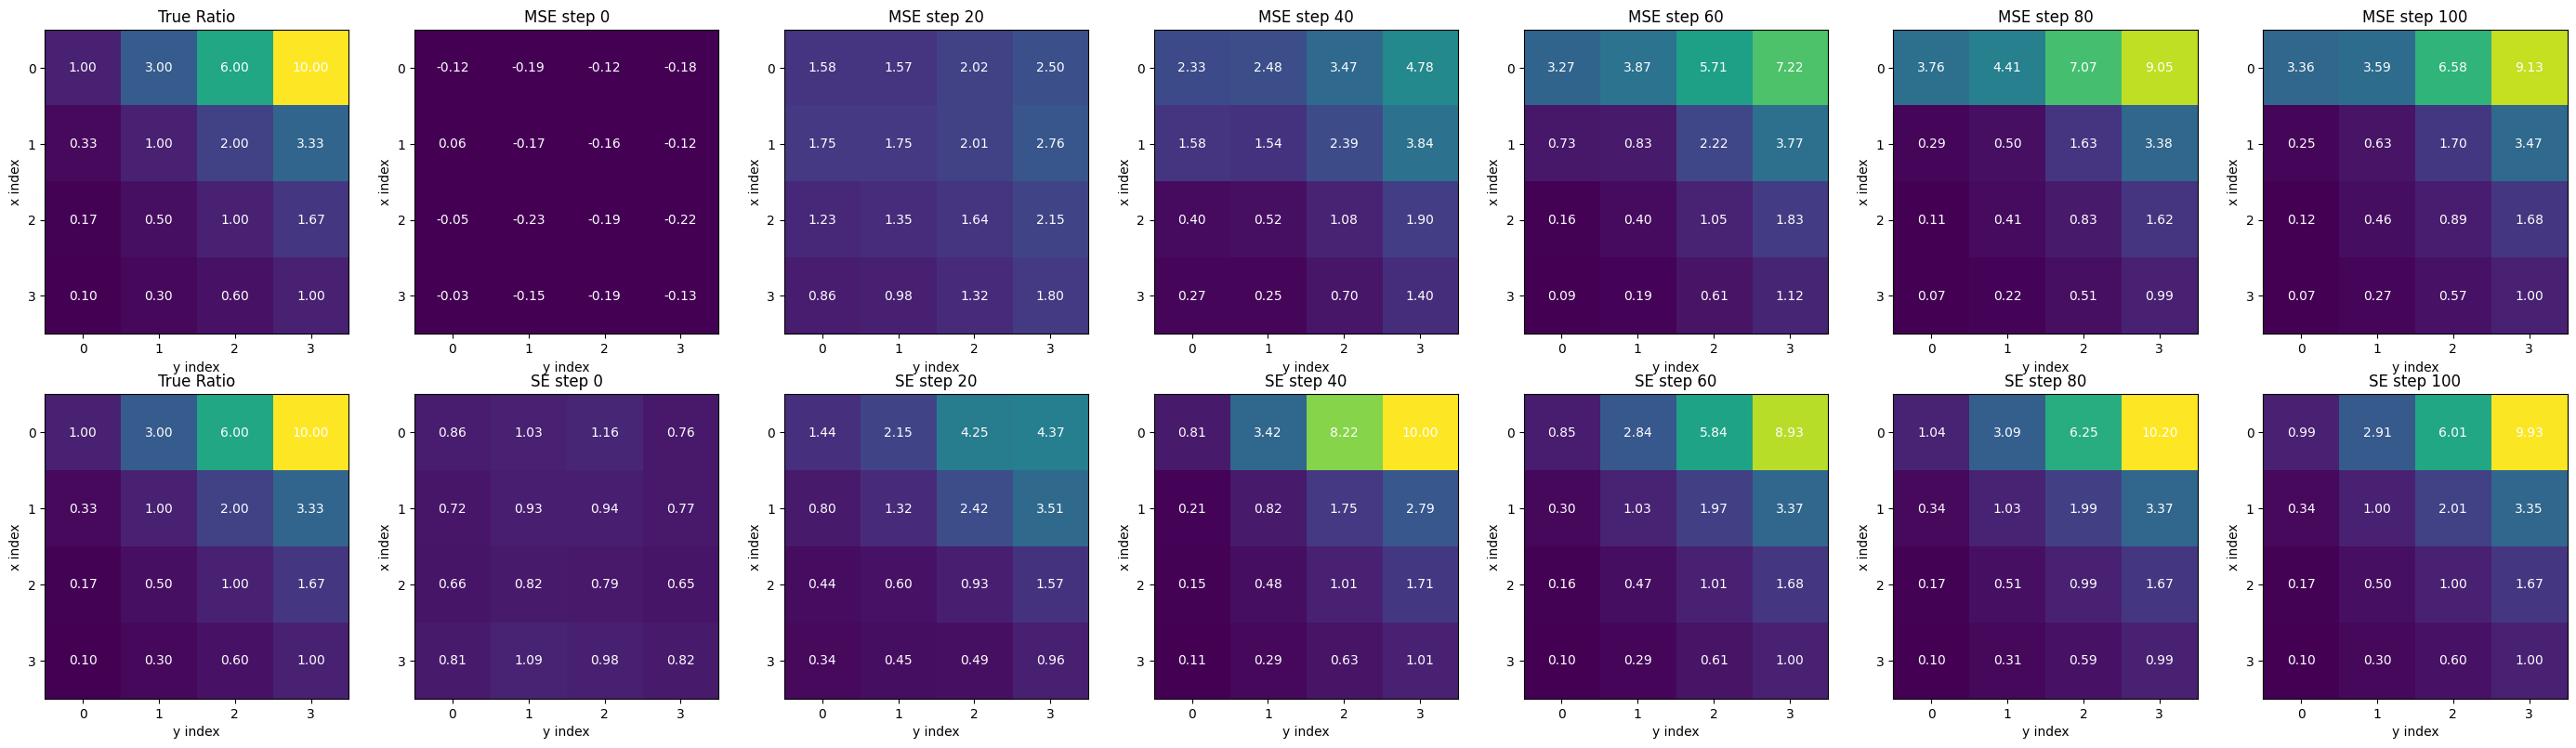

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# ============================
# 1. Define discrete distribution p_t(x)
# ============================
p = torch.tensor([0.05, 0.15, 0.30, 0.50])
p = p / p.sum()
true_ratio = p.view(1, 4) / p.view(4, 1)
true_log_ratio = torch.log(true_ratio)

vmin, vmax = true_ratio.min().item(), true_ratio.max().item()


# ============================
# Plot heatmap utility
# ============================
def plot_heatmap(ax, matrix, title, vmin=None, vmax=None):
    """Plot a heatmap into a given subplot axis."""
    im = ax.imshow(matrix, cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("y index")
    ax.set_ylabel("x index")
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))

    # Write numeric values inside each cell
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="white")

    return im


# ============================
# 2. Neural network for ratio prediction
# ============================
class RatioNet(nn.Module):
    """A small MLP taking one-hot(x) + one-hot(y) and predicting ratio or log-ratio."""

    def __init__(self, output_log_ratio=False):
        super().__init__()
        self.output_log_ratio = output_log_ratio
        self.net = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x_idx, y_idx):
        x_oh = F.one_hot(x_idx, num_classes=4).float()
        y_oh = F.one_hot(y_idx, num_classes=4).float()
        inp = torch.cat([x_oh, y_oh], dim=-1)
        out = self.net(inp).squeeze(-1)
        return out


# ============================
# Build evaluation grid
# ============================
xs = torch.arange(4)
ys = torch.arange(4)
grid_x, grid_y = torch.meshgrid(xs, ys, indexing="ij")
all_x = grid_x.reshape(-1)
all_y = grid_y.reshape(-1)
true_log_r_flat = true_log_ratio.reshape(-1)


# ==========================================================
# Score Entropy Loss
# ==========================================================
def score_entropy_loss(pred_log_r):
    """Score Entropy Loss from SEDD."""
    px = p[all_x]
    py = p[all_y]
    w = px * py
    return ((pred_log_r - true_log_r_flat) ** 2 * w).sum()


# ==========================================================
# Create two models
# ==========================================================
model_mse = RatioNet(output_log_ratio=False)
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

model_se = RatioNet(output_log_ratio=True)
optimizer_se = torch.optim.Adam(model_se.parameters(), lr=1e-2)


# ==========================================================
# Utilities to compute predicted ratio matrices
# ==========================================================
def get_ratio_matrix_mse(model):
    with torch.no_grad():
        preds = model(all_x, all_y).reshape(4, 4)
    return preds.numpy()


def get_ratio_matrix_se(model):
    with torch.no_grad():
        preds = model(all_x, all_y).reshape(4, 4).exp()
    return preds.numpy()


# ==========================================================
# Plot schedule
# ==========================================================
plot_steps = [0, 20, 40, 60, 80, 100]
max_steps = 1000
batch_size = 64

mse_snapshots = {0: get_ratio_matrix_mse(model_mse)}
se_snapshots = {0: get_ratio_matrix_se(model_se)}


# ==========================================================
# Training loop
# ==========================================================
for step in range(1, max_steps + 1):

    # ---------------- MSE model ----------------
    x_idx = torch.multinomial(p, batch_size, replacement=True)
    y_idx = torch.multinomial(p, batch_size, replacement=True)
    true_values = p[y_idx] / p[x_idx]

    pred_values = model_mse(x_idx, y_idx)
    loss_mse = mse_loss_fn(pred_values, true_values)

    optimizer_mse.zero_grad()
    loss_mse.backward()
    optimizer_mse.step()

    # ---------------- Score Entropy model ----------------
    pred_log_r = model_se(all_x, all_y)
    loss_se = score_entropy_loss(pred_log_r)

    optimizer_se.zero_grad()
    loss_se.backward()
    optimizer_se.step()

    # Store snapshots
    if step in plot_steps:
        print(f"[Step {step}]  MSE Loss={loss_mse.item():.4f},  SE Loss={loss_se.item():.6f}")
        mse_snapshots[step] = get_ratio_matrix_mse(model_mse)
        se_snapshots[step] = get_ratio_matrix_se(model_se)


# ==========================================================
# Final 2-row Visualization with TRUE RATIO as first column
# ==========================================================

num_cols = len(plot_steps) + 1  # +1 for true ratio column
fig, axes = plt.subplots(2, num_cols, figsize=(4 * num_cols, 8))

# Column 0: True heatmap
for row in range(2):
    plot_heatmap(axes[row, 0], true_ratio.numpy(), "True Ratio", vmin, vmax)

# Remaining columns: model predictions
for j, step in enumerate(plot_steps):
    # Row 1: MSE
    plot_heatmap(axes[0, j + 1], mse_snapshots[step], f"MSE step {step}", vmin, vmax)

    # Row 2: Score Entropy
    plot_heatmap(axes[1, j + 1], se_snapshots[step], f"SE step {step}", vmin, vmax)

plt.tight_layout()
plt.show()
